**End to end Face Detection**

Before we start with the project we need to setup our environment and get the data ready which can be done as follow:
* installing all the dependencies
* collecting images

In [1]:
#getting all the dependencies 
%pip install labelme tensorflow opencv-python matplotlib albumentations

Note: you may need to restart the kernel to use updated packages.


**Collecting images using OpenCV**

we will be using OpenCV to access our images and them annotate them using Label me...

In [2]:
#importing all the libraries
import os
import time
import uuid #giving our images a unique ID 
import cv2

In [3]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [10]:
#using a custom for loop to capture our images and saving them in the defined path for further analysis
cap = cv2.VideoCapture(0) #change this based on your camra input
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [4]:
#now we need to annotate our images using LabelMe
!labelme

2024-10-26 23:06:25,691 [INFO   ] __init__:get_config:67- Loading config file from: C:\Users\Amir\.labelmerc


**Bulding our image intergration function**

after capturing and annotating our images now we need to review our data and then build a function that would load them.


In [5]:
#importing our libraries:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [6]:
#loading our images:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')
images.as_numpy_iterator().next()

b'data\\images\\daadb6a9-93e2-11ef-9efe-98bb1e1c5484.jpg'

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[125, 118, 108],
        [125, 118, 108],
        [125, 118, 108],
        ...,
        [124, 126, 123],
        [124, 126, 123],
        [123, 125, 122]],

       [[123, 116, 106],
        [124, 117, 107],
        [124, 117, 107],
        ...,
        [123, 125, 122],
        [123, 125, 122],
        [122, 124, 121]],

       [[122, 115, 107],
        [123, 116, 108],
        [124, 117, 109],
        ...,
        [123, 127, 126],
        [122, 126, 125],
        [121, 125, 124]],

       ...,

       [[ 24,  33,  40],
        [ 24,  33,  38],
        [ 28,  33,  37],
        ...,
        [ 41,  46,  50],
        [ 45,  49,  52],
        [ 46,  50,  53]],

       [[ 19,  34,  41],
        [ 21,  34,  40],
        [ 25,  35,  36],
        ...,
        [ 40,  45,  49],
        [ 41,  46,  50],
        [ 42,  47,  51]],

       [[ 17,  34,  41],
        [ 20,  35,  40],
        [ 25,  37,  37],
        ...,
        [ 39,  44,  48],
        [ 39,  44,  48],
        [ 39,  44,  48]]

In [10]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

**Visualising our images**

in this section we will be using Matplotlib to visualise our raw images

which can help us to understand our data furthemore.


In [11]:
image_generator = images.batch(4).as_numpy_iterator()

In [12]:
plot_images = image_generator.next()

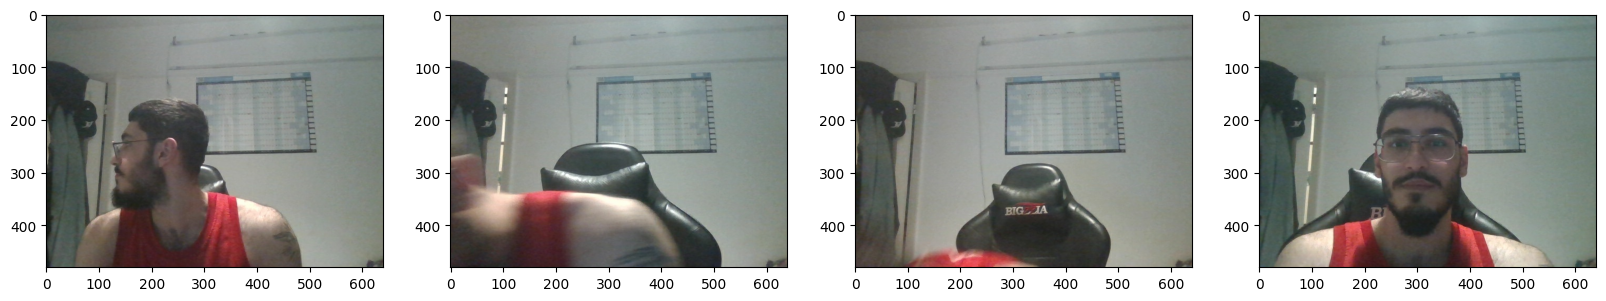

In [13]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()
#test

**Managing our un-augmented data**

we also need to split our data into trining and testing set which will be done manually:

so I have split the images into the followings:
* 63 for the training images.
* 14 for test.
* 13 for validation


In [19]:
#now moving our labels into the labels for each datasets using a for loop
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

**performing image augmentation**

Since we only have 90 images (which is not enough, it never is enough) now we have to augment our images so we can train our model more effectively. this process will be done using Albumentations.

In [60]:
import albumentations as alb

In [61]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

**Loading our images**

in this section we will be using OpenCV and JSON to load our images 

In [62]:
#loading up a random image
img = cv2.imread(os.path.join('data','train', 'images','d9228308-93e2-11ef-a331-98bb1e1c5484.jpg'))

In [63]:
#loading in out label for the same image 
with open(os.path.join('data', 'train', 'labels', 'd9228308-93e2-11ef-a331-98bb1e1c5484.json'), 'r') as f:
    label = json.load(f)

In [64]:
label['shapes'][0]['points']

[[198.84615384615384, 169.6703296703297],
 [335.1098901098901, 381.2087912087912]]

**getting our image coordinations**

in order to input our images into our model we need to understand what is our input image size, resolution etc.
* Note: since we're using Albumentations we need to make sure that our bounding box coordinations are correct e.g., it should be as follow:
[x_min, y_min, x_max, y_max]. The values are normalized by dividing the pixel coordinates for the x- and y-axis by the image's width and height.


In [65]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [66]:
coords

[198.84615384615384, 169.6703296703297, 335.1098901098901, 381.2087912087912]

In [67]:
#getting our image size:
img.shape

(480, 640, 3)

In [68]:
coords = list(np.divide(coords, [640,480,640,480]))

In [69]:
coords

[np.float64(0.31069711538461536),
 np.float64(0.3534798534798535),
 np.float64(0.5236092032967032),
 np.float64(0.7941849816849816)]

**Augmentations**

in this section we will be adding our augmented images and view our results.
* in this section we will fine-tune our "augmentor" function that we built earlier and see if it works. Then in the next section we will apply the augmentor function to all the images.


In [74]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [75]:
augmented['bboxes'][0][2:]

[0.707008556789822, 0.780463981628418]

In [76]:
augmented['bboxes']

[[0.4042002190483941,
  0.3103785196940104,
  0.707008556789822,
  0.780463981628418]]

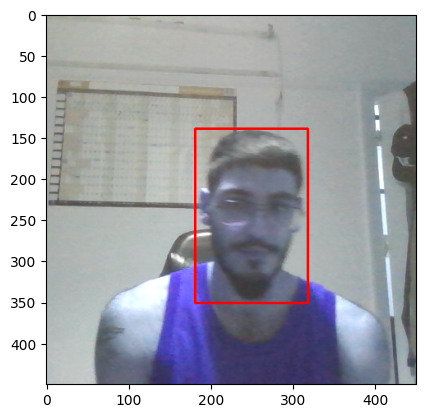

In [77]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),      #top most coordinates 
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),      #bottom most coordinates
                    (255,0,0), 2)

plt.imshow(augmented['image'])

**building our Pipeline**

in this section we will be building a pipeline that would apply our augmentation process.


In [ ]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)